## One-Day Workshop @ NSTL

### Ritajit Majumdar
Research Scientist @ IBM Quantum

### Components of quantum computation

#### Qubits
Qubits are always initialized to $|0\rangle$

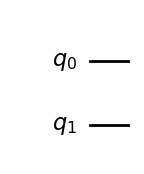

In [1]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(2) # 2 qubit quantum circuit
qc.draw('mpl')

#### Evolution of the qubits -- `quantum gates`

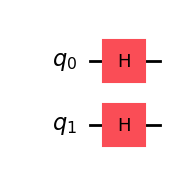

In [2]:
qc.h(0)
qc.h(1)

qc.draw('mpl')

Hadamard gate creates equal superposition: $|0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. In our example, the evolved state is $|00\rangle \rightarrow \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$.

#### Measurement
Measurement of a quantum state $\alpha|0\rangle + \beta|1\rangle$ collapses the state to either $0$ with probability $|\alpha|^2$ or $1$ with probability $|\beta|^2$. For our example state, the outcome will be any one of $00, 01, 10, 11$ with probability $\frac{1}{4}$.

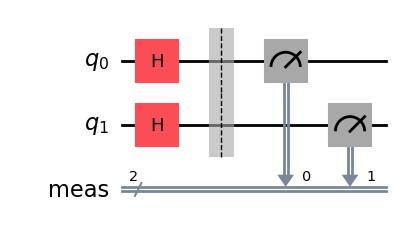

In [3]:
qc.measure_all()
qc.draw('mpl')

#### Execute using Qiskit Primitive

Qiskit Runtime offers two primitives - Sampler and Estimator. The former is used to obtain the probability distribution of a circuit. In this section, we shall see the usage of Sampler.

You can install the latest version of Qiskit Runtime by *pip install qiskit-ibm-runtime*. Note that with Qiskit 1.0, you may need to separately install qiskit-aer by *pip install qiskit-aer*.

In [4]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2

backend = AerSimulator()
sampler = SamplerV2(backend=backend)
sampler.options.default_shots = 1

In [6]:
# Run this multiple times
job = sampler.run([qc])
result = job.result()[0]
counts = result.data.meas.get_counts()
counts

{'01': 1}

To obtain the distribution of the circuit, we can increase the number of `shots`.

In [7]:
sampler.options.default_shots = 1000

job = sampler.run([qc])
result = job.result()[0]
counts = result.data.meas.get_counts()

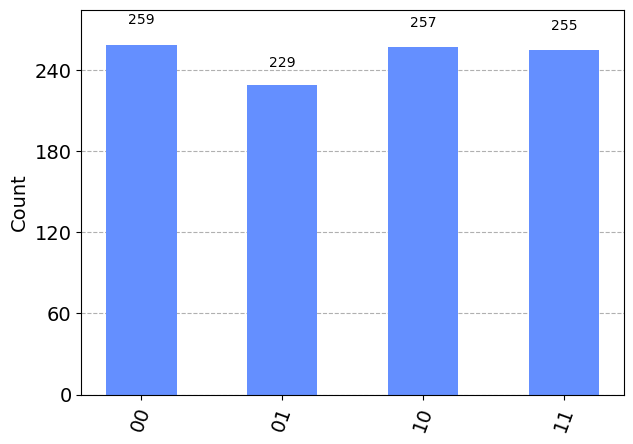

In [8]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

#### <p style="color:red;">Caution: Qiskit uses Little-endian convention</p>

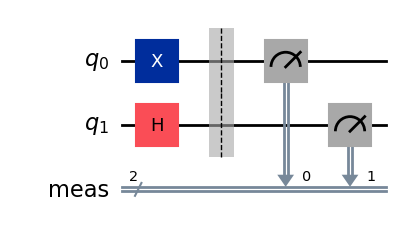

In [9]:
qc = QuantumCircuit(2)
qc.x(0)
qc.h(1)
qc.measure_all()

qc.draw('mpl')

$|00\rangle \rightarrow |1\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle \rightarrow \frac{1}{\sqrt{2}}(|10\rangle + |11\rangle$.

When measured
<ul>
    <li>The first qubit collapses to $1$ with probability 1.</li>
    <li>The second qubit collapses to either $0$ with probability $|\frac{1}{\sqrt{2}}|^2 = \frac{1}{2}$ or $1$ with probability $|\frac{1}{\sqrt{2}}|^2 = \frac{1}{2}$</li>
</ul>

Therefore, the outcome will be $10$ with probability $\frac{1}{2}$ or $11$ with probability $\frac{1}{2}$.

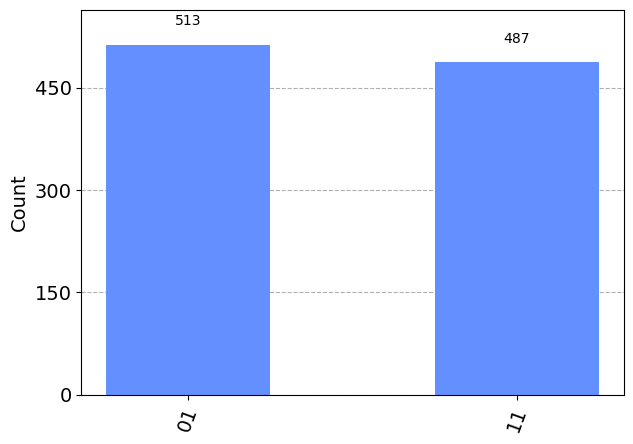

In [10]:
job = sampler.run([qc])
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_histogram(counts)

### Taking a deeper dive

#### Q1. How to initialize a qubit in some other state?

Example: We want to initialize the qubit in state $\frac{1}{\sqrt{3}}|0\rangle + \sqrt{\frac{2}{3}}|1\rangle$.

The statevector notation of this state is $\begin{pmatrix}
\frac{1}{\sqrt{3}}\\
\sqrt{\frac{2}{3}}
\end{pmatrix}$

In [11]:
import numpy as np

initial_state = [1/np.sqrt(3),np.sqrt(2/3)]
initial_state

[0.5773502691896258, 0.816496580927726]

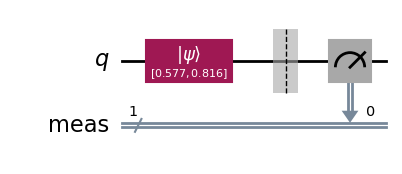

In [12]:
qc = QuantumCircuit(1)
qc.initialize(initial_state,0)
qc.measure_all()

qc.draw('mpl')

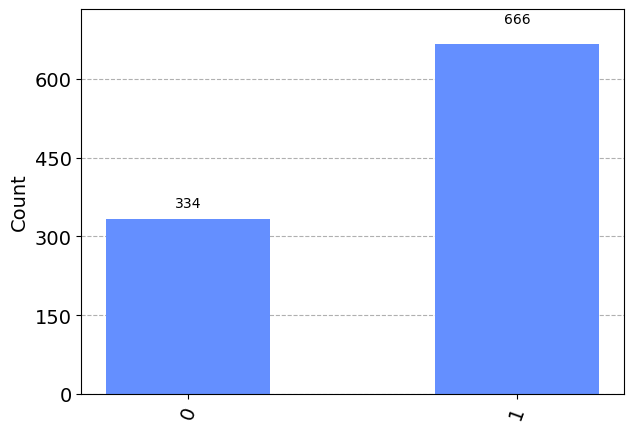

In [13]:
job = sampler.run([qc])
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_histogram(counts)

#### Q2. How to define my own quantum gate?

In [14]:
my_unitary = np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
my_unitary

matrix([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

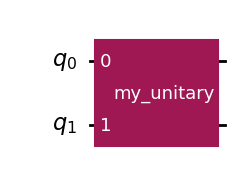

In [16]:
from qiskit.quantum_info import Operator

qc = QuantumCircuit(2)
qc.unitary(Operator(my_unitary),[0,1],label='my_unitary')
qc.draw('mpl')

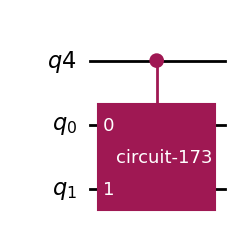

In [17]:
qc_ctrl = qc.control()
qc_ctrl.draw('mpl')

Let us now add this gate on some other quantum circuit

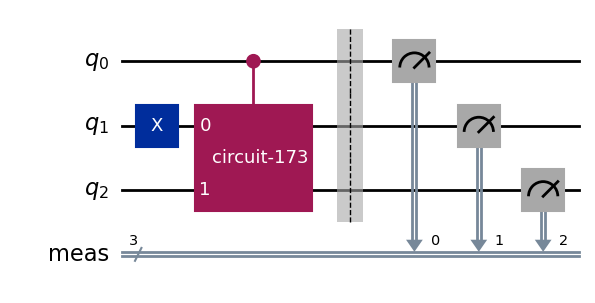

In [18]:
circ = QuantumCircuit(3)
circ.x(1)
#circ.x(0)
circ.compose(qc_ctrl, qubits=[0,1,2], inplace=True)
circ.measure_all()
circ.draw('mpl')

In [19]:
# Show that error occurs when not transpiled
job = sampler.run([circ])
result = job.result()[0]

AerError: 'unknown instruction: ccircuit-173'

It is now necessary to provide `isa_circuits` for execution.

In [20]:
## Show the ibm_quantum_experience to discuss about basis gates

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, basis_gates=['x','sx','rz','id','ecr'])

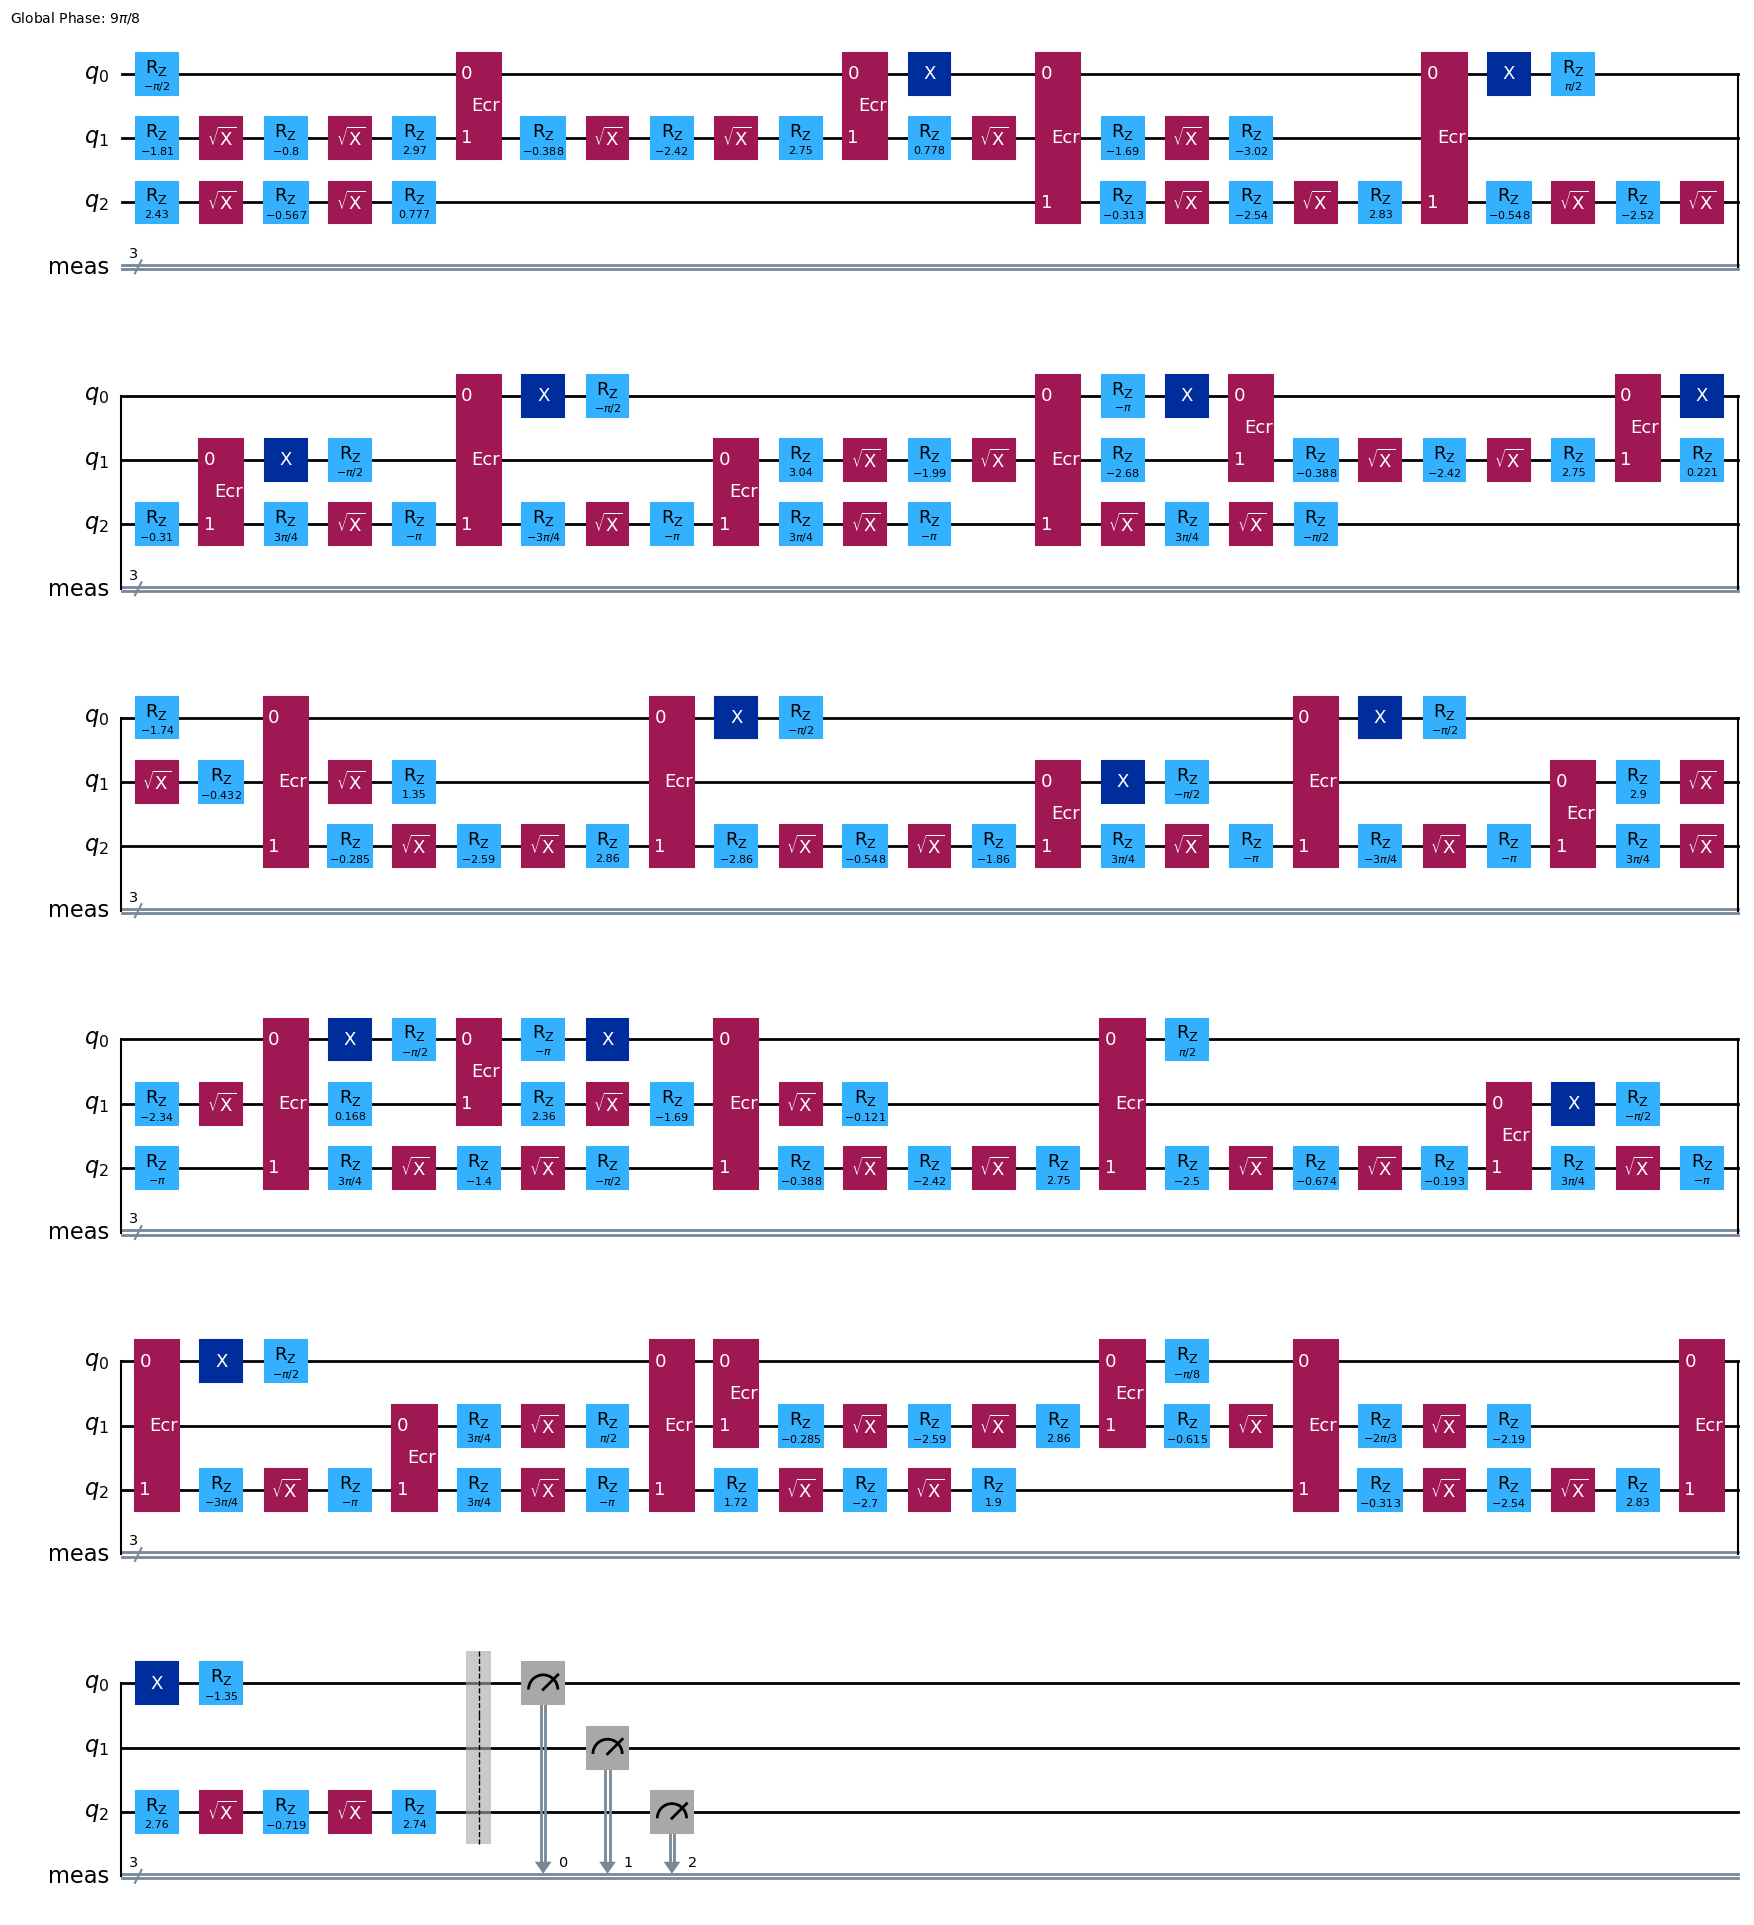

In [21]:
trans_circ = pm.run(circ)
trans_circ.draw('mpl')

In [22]:
trans_circ.depth()

125

In [23]:
trans_circ.depth(lambda x:x[0].num_qubits==2)

27

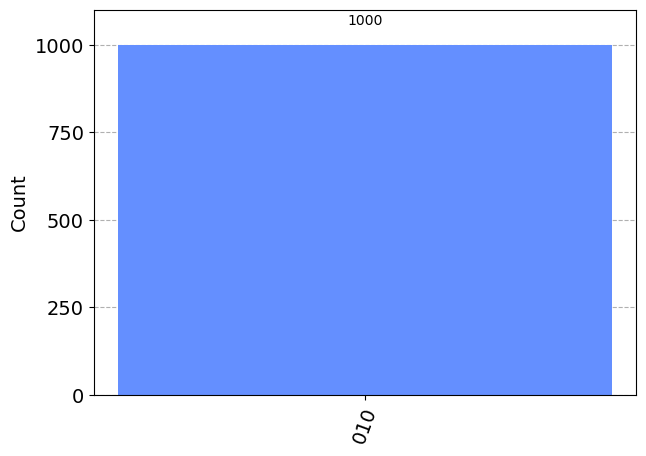

In [24]:
job = sampler.run([trans_circ])
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_histogram(counts)

#### Q3. Are there some pre-defined circuit templates?

Yes, `qiskit.circuit.library` contains a plethora of pre-defined circuit templates which can be directly used for execution.

##### Ex 1. Grover Circuit

Grover Algorithm can search for a marked state from an unstructured databased consisting of $2^n$ elements in $O(\sqrt{2^n})$. This provides a quadratic speedup over classical algorithm.

Consider a 3-qubit scenario with the marked state being $|011\rangle$. Recall that the diffusion operator is given by $2|000\rangle \langle000| - I_3$.

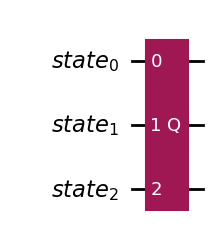

In [25]:
from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info import Statevector, DensityMatrix

marked_state = Statevector.from_label('011')
diffusion_operator = 2 * DensityMatrix.from_label('000') - Operator.from_label('III')

grover_op = GroverOperator(oracle=marked_state, zero_reflection=diffusion_operator)
grover_op.draw('mpl')

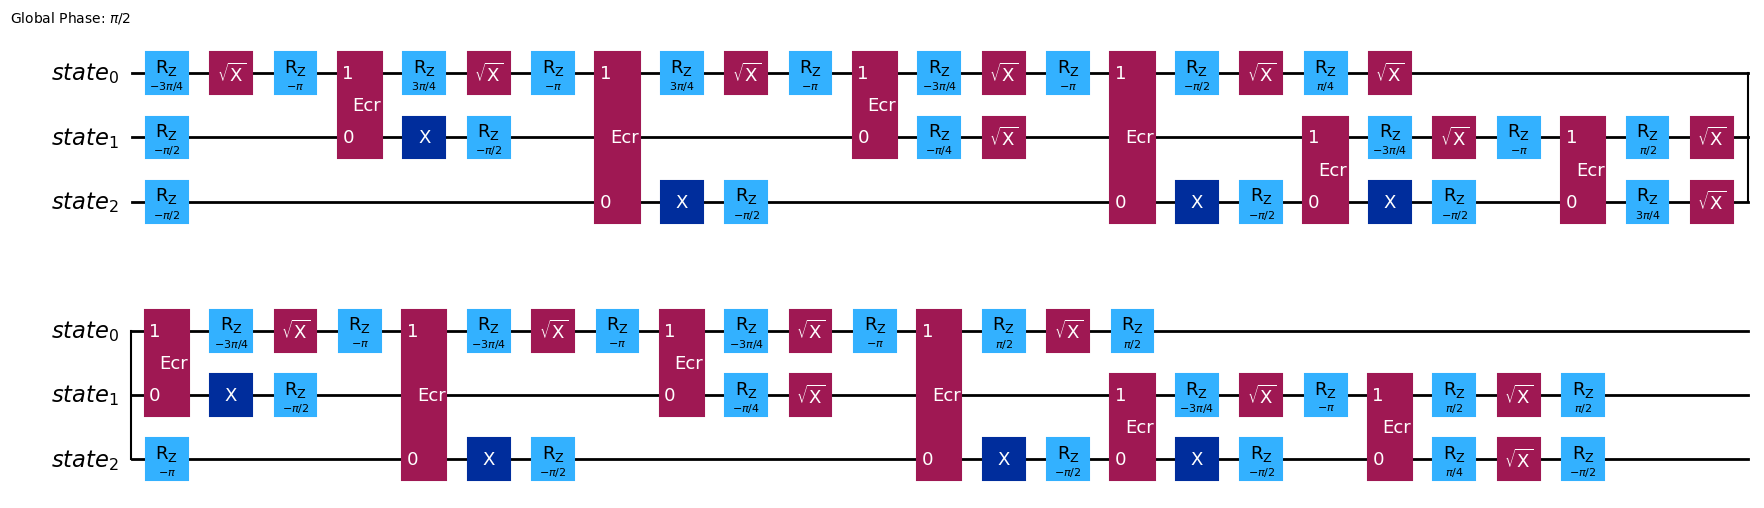

In [26]:
transpiled_grover = pm.run(grover_op)
transpiled_grover.draw('mpl')

##### Ex 2. Quantum Fourier Transform Circuit

The Quantum Fourier Transform (QFT) on $n$ qubits is the operation

<center>$|j\rangle \rightarrow \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n -1} e^{2\pi j k/2^n}|k\rangle$</center>

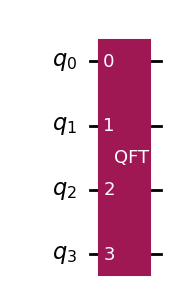

In [27]:
from qiskit.circuit.library import QFT

qft = QFT(num_qubits=4)
qft.draw('mpl')

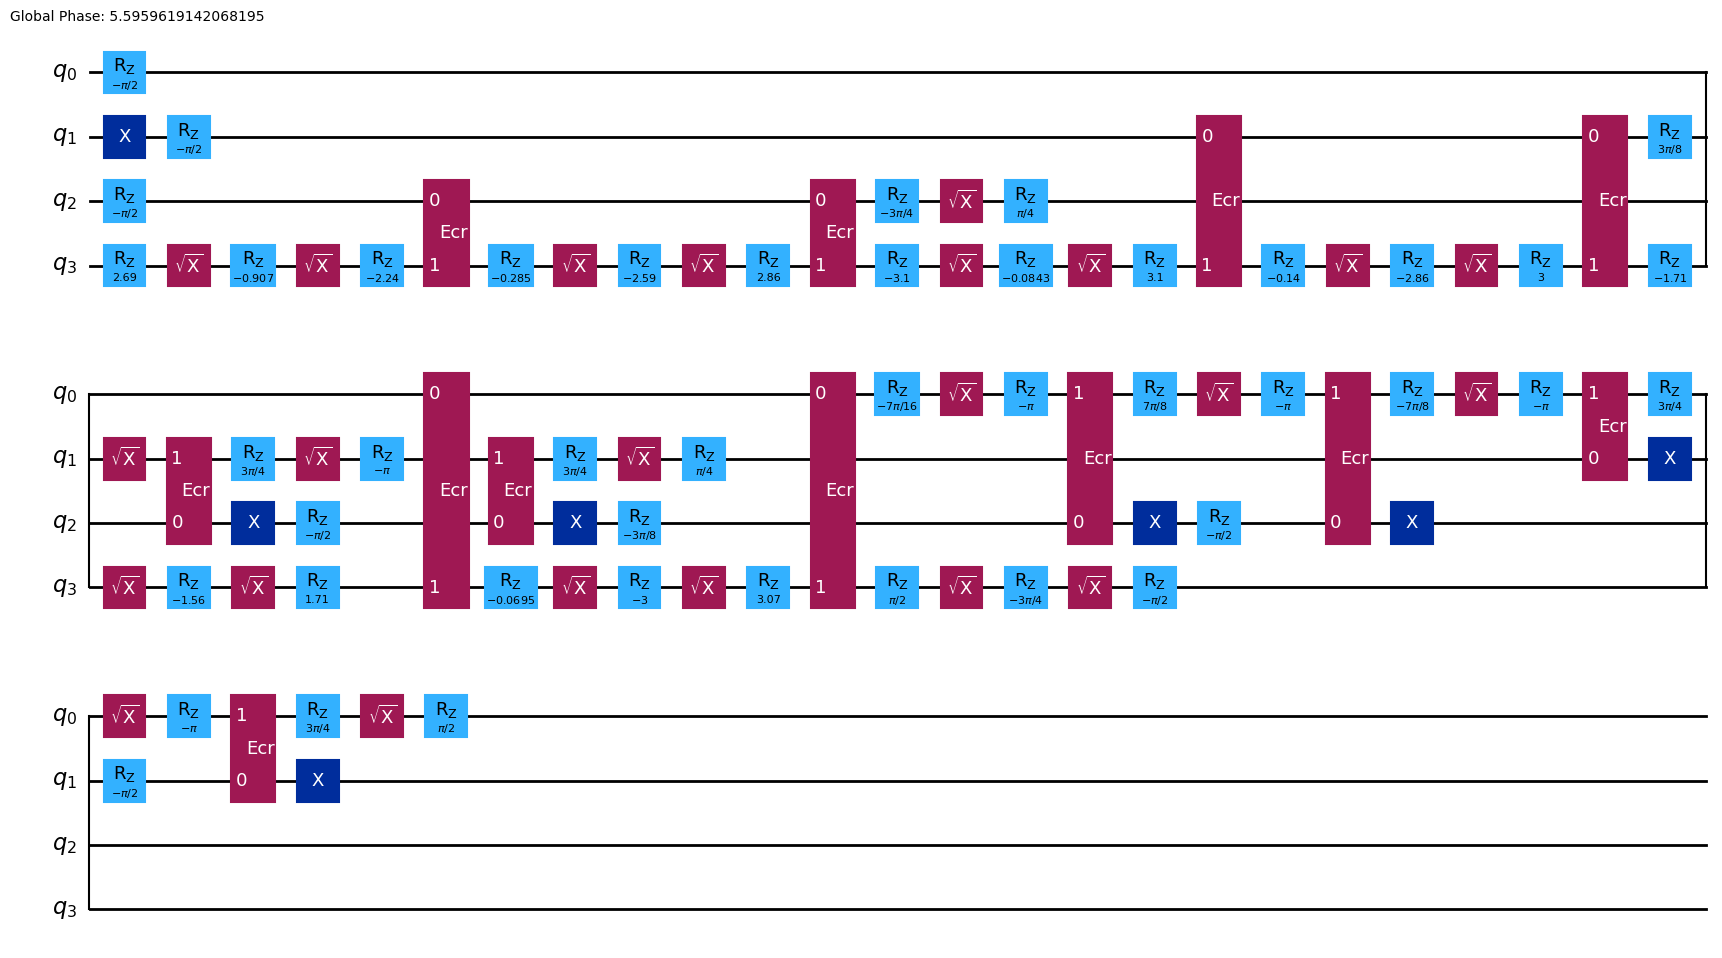

In [28]:
transpiled_qft = pm.run(qft)
transpiled_qft.draw('mpl')

### Calculating expectation value from probability distribution

#### For observables diagonal in Z basis

In [29]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

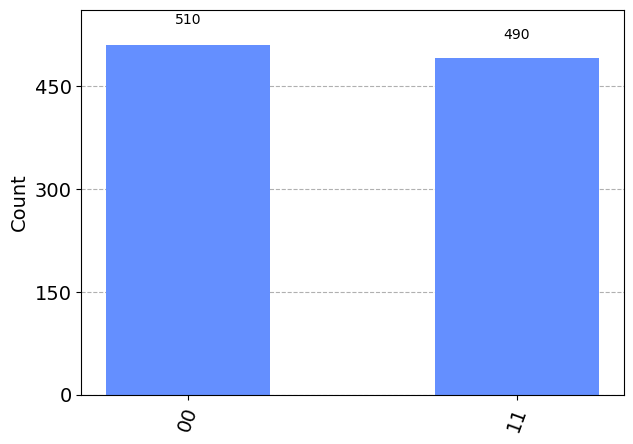

In [30]:
job = sampler.run([qc])
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_histogram(counts)

Let us assume that we want to calculate the expectation value of $\langle ZZ \rangle$ for the Bell state. We can do that by using the `sampled_expectation_value` function, and the `SparsePauliOp` class for observables.

In [31]:
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp

In [32]:
observable_zz = SparsePauliOp('ZZ')
observable_zz

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])

In [33]:
expval_zz = sampled_expectation_value(counts, observable_zz)
print(f'Expectation value of <ZZ> is {expval_zz}')

Expectation value of <ZZ> is 1.0


We can similarly calculate the expcation value of observables like, say, $\langle ZI \rangle$.

In [34]:
observable_zi = SparsePauliOp('ZI')
expval_zi = sampled_expectation_value(counts, observable_zi)
print(f'Expectation value of <ZI> is {expval_zi}')

Expectation value of <ZI> is 0.02


Note that the ideal expecation value of $\langle ZI \rangle$ is 0. But that is in the range of infinite shots. The more we increase the number of shots, the closer will this value be to 0.

#### For observables which are not diagonal in Z basis

If the observable is not diagonal in $Z$ basis, then it is necessary to change the measurement basis. But quantum hardware can measure only in $Z$ basis. So we apply a unitary *before measurement* in order to set the correct rotation. For measurement in $X$ basis, we need to add a Hadamard gate before measurement since HZH = X.

Let us measure the expectation value of $\langle XX \rangle$.

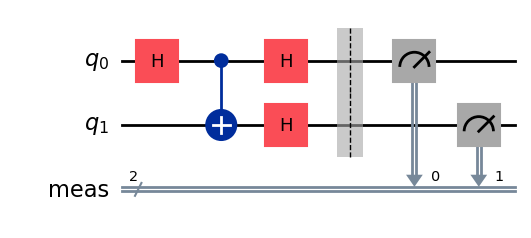

In [35]:
qc_x = qc.copy()
qc_x.remove_final_measurements()
qc_x.h([0,1]) # these hadamard gates ensure that now measurement is in X basis
qc_x.measure_all()

qc_x.draw('mpl')

##### Y type observables

For Y type observable, we need to apply a Hadamard gate followed by a $S^{\dagger}$ gate before measurement. This rotation ensures measurement Y basis.

Let us assume that you want to calculate the expectation values of multiple observables on the circuit: say 1. $\langle ZI \rangle$, 2. $\langle ZX \rangle$, 3. $\langle YX \rangle$, 4. $\langle IX \rangle$.

Note that for these four observables, the brute-force method will be to create four different circuits to measure these. But if two observables commute qubit-wise, then a single circuit is sufficient to calculate the expectation value of both the observables.

In this example, $[ZI, IX] = 0$, $[ZI, ZX] = 0$ and $[ZX, IX] = 0$. Therefore, it is possible to construct a single circuits to measure all three of these observables. Another circuit is required to measure $\langle YX \rangle$. Therefore, only two circuits are sufficient.

<b>Food for thought</b>: What should be the rotations for the measurement on each circuit so that we can measure $\langle ZI \rangle$, $\langle ZX \rangle$ and $\langle IX \rangle$ using a single circuit?

<b>All these intricate calculations on the minimum number of circuits needed, the rotation required for each qubit are taken care of by the Qiskit Runtime Primitive: Estimator</b>.

### Obtaining the expectation value: Introduction to Estimator

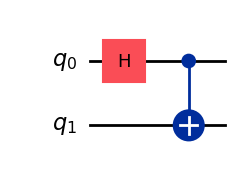

In [36]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

Let us consider a list of observables for which we want to calculate the expectation values.

In [37]:
from qiskit.quantum_info import SparsePauliOp

observables = [
    SparsePauliOp('ZI'),
    SparsePauliOp('ZX'),
    SparsePauliOp('YX'),
    SparsePauliOp('IX'),
    SparsePauliOp('ZZ')
]

observables

[SparsePauliOp(['ZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['YX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZZ'],
               coeffs=[1.+0.j])]

In [38]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=backend)

job = estimator.run([(qc, observables)])
result = job.result()[0]

In [39]:
expvals = result.data.evs
expvals

array([ 0.02734375, -0.01953125, -0.01220703,  0.00976562,  1.        ])

Now let us assume that the final value which we wanted to calculate was some linear combination of these expectation values. For example: $O = 0.1\langle ZI \rangle - 0.5\langle ZX \rangle + 0.3\langle YX \rangle + 0.2\langle IX \rangle - 0.4\langle ZZ \rangle$. We can obtain the individual expectation values (like we did for this example), and calculate the linear combination manually, or we can pass in the observable with proper coefficients for `estimator` to handle it.

In [40]:
obs = SparsePauliOp(['ZI','ZX','YX','IX','ZZ'], coeffs=[0.1,-0.5,0.3,0.2,-0.4])
obs

SparsePauliOp(['ZI', 'ZX', 'YX', 'IX', 'ZZ'],
              coeffs=[ 0.1+0.j, -0.5+0.j,  0.3+0.j,  0.2+0.j, -0.4+0.j])

In [41]:
job = estimator.run([(qc, obs)])
result = job.result()[0]

In [42]:
expval_combined = result.data.evs
print(f'The expectation value of O is {expval_combined}')

The expectation value of O is -0.393359375


### Mind your hardware constraints

In [43]:
from qiskit_ibm_runtime.fake_provider import FakeKolkata

backend = FakeKolkata()

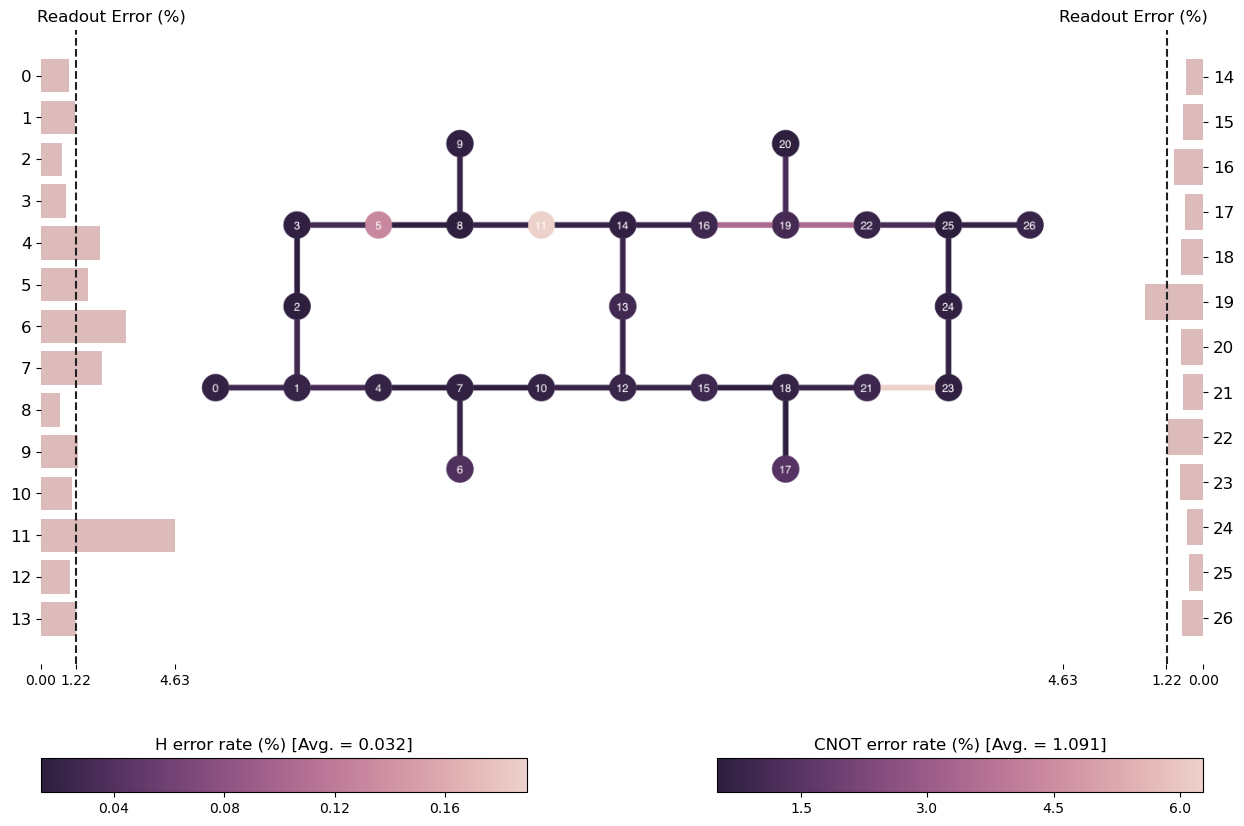

In [44]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, show_title=False)

In order to run a circuit on the hardware, it is necessary to transpile the circuit. Transpilation maps the circuit to the basis gates of the backend, and adds swap gates whenever necessary to make the circuit amenable to the coupling map.

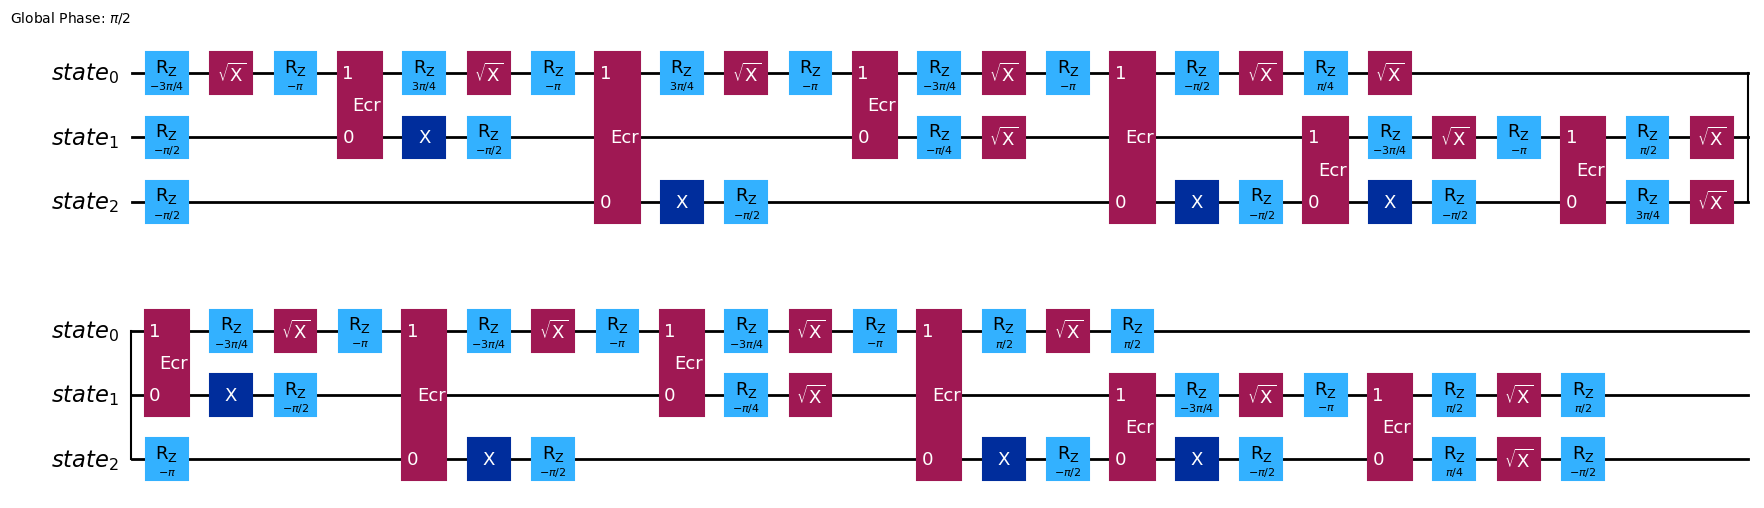

In [45]:
example_circuit = transpiled_grover
example_circuit.draw('mpl')

In [46]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm_swap = generate_preset_pass_manager(optimization_level=3, coupling_map=backend.configuration().coupling_map,
                                      basis_gates=['x','sx','rz','cx','id','swap'])
swap_isa_circuit = pm_swap.run(example_circuit)

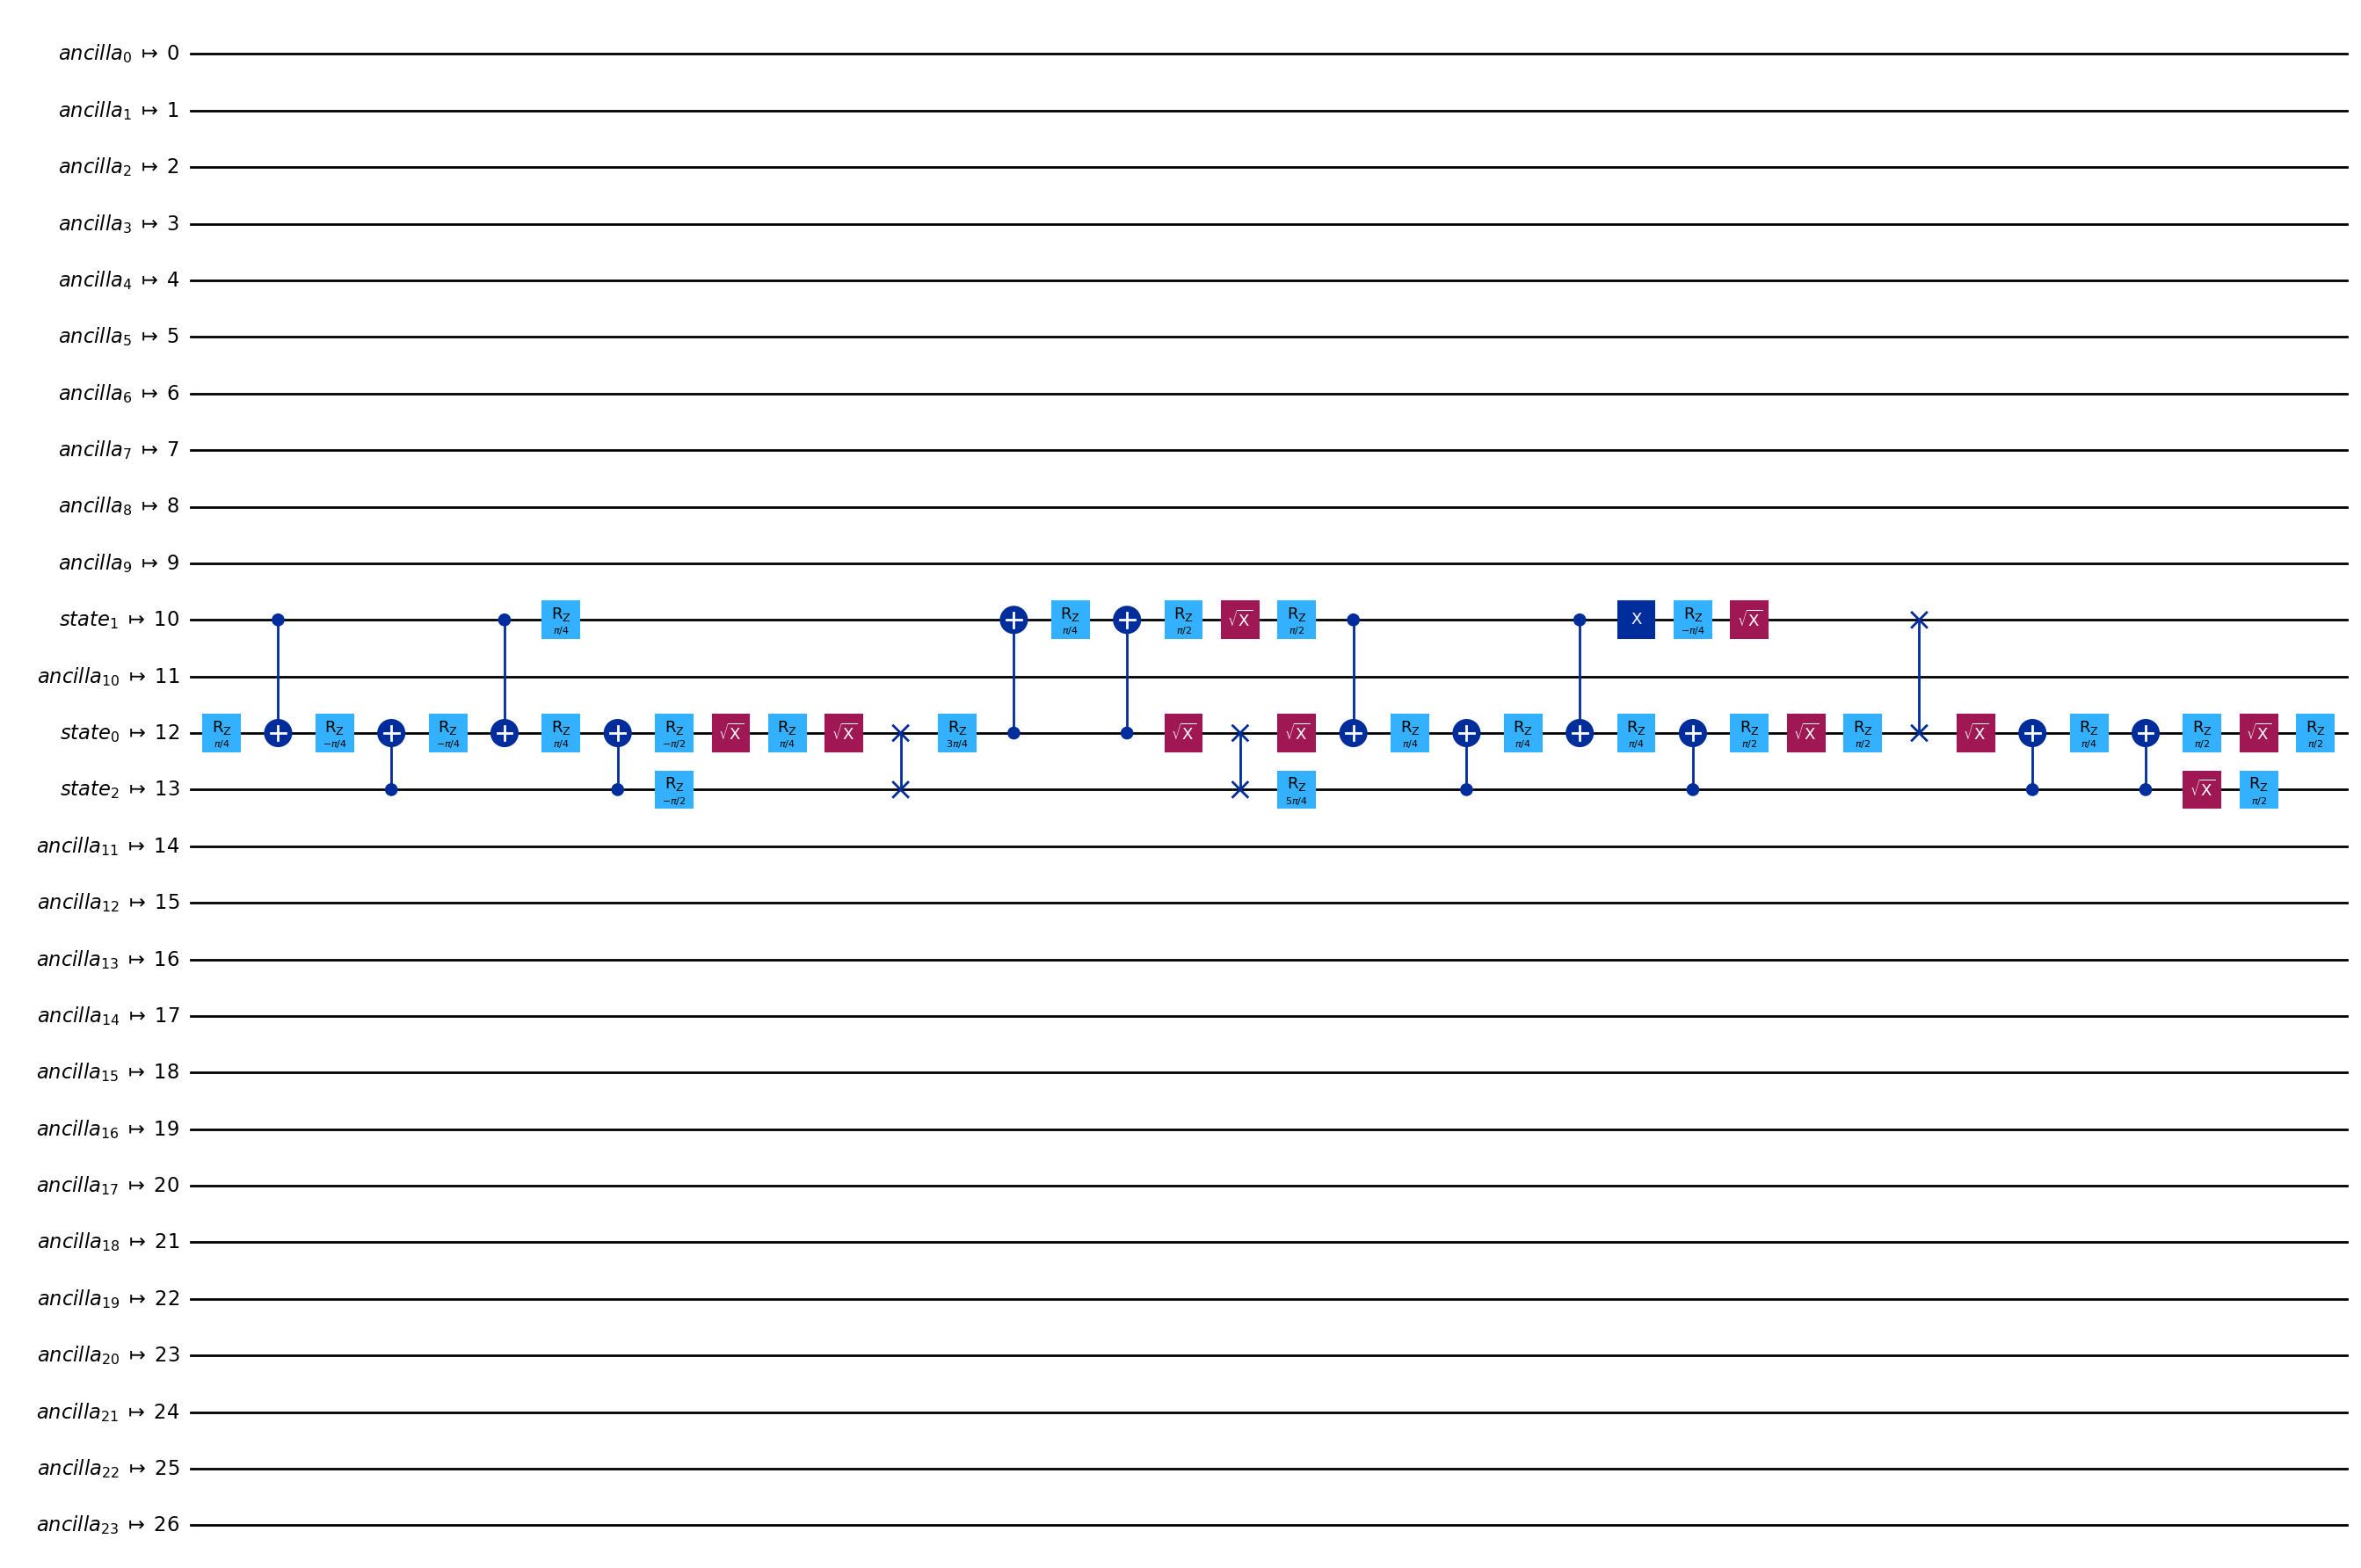

In [47]:
swap_isa_circuit.draw('mpl', fold=-1)

In [48]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(example_circuit)

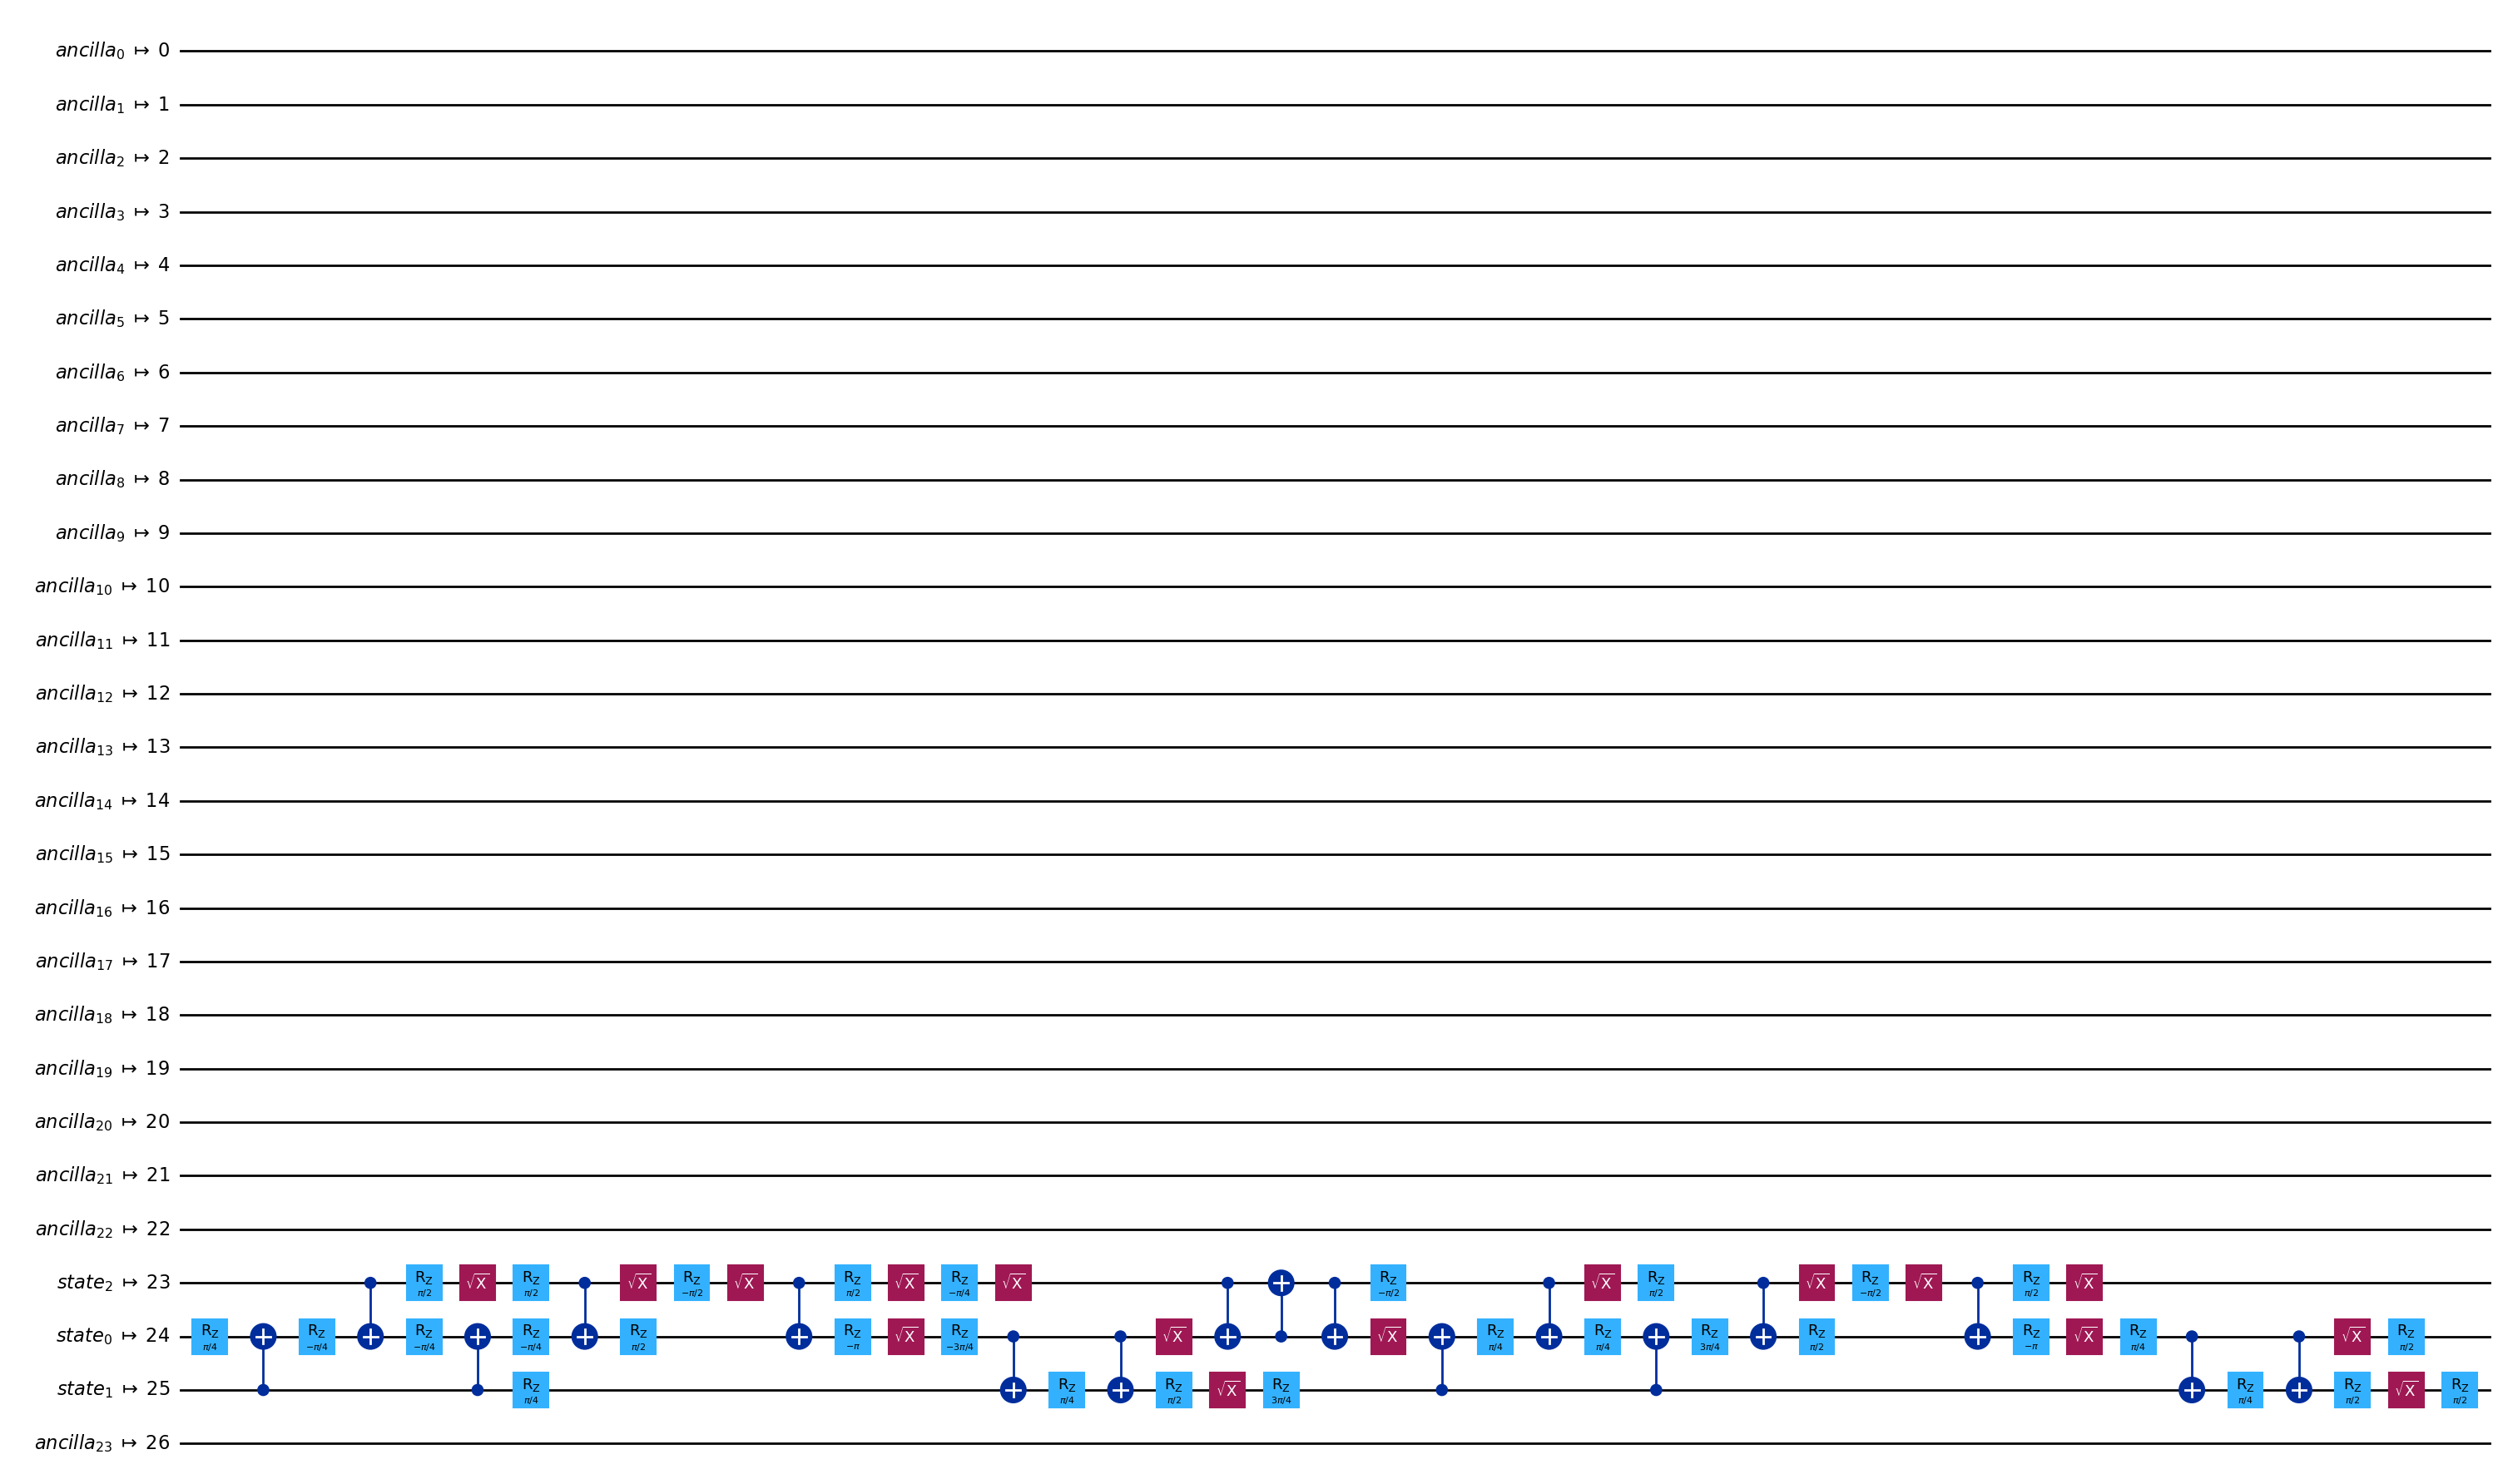

In [49]:
isa_circuit.draw('mpl', fold=-1)

In [50]:
isa_circuit.measure_active()

In [51]:
sim_backend = AerSimulator()
sim_sampler = SamplerV2(backend=sim_backend)
sampler = SamplerV2(backend=backend)

In [52]:
sim_job = sim_sampler.run([isa_circuit])
job = sampler.run([isa_circuit])

In [53]:
sim_counts = sim_job.result()[0].data.measure.get_counts()
counts = job.result()[0].data.measure.get_counts()

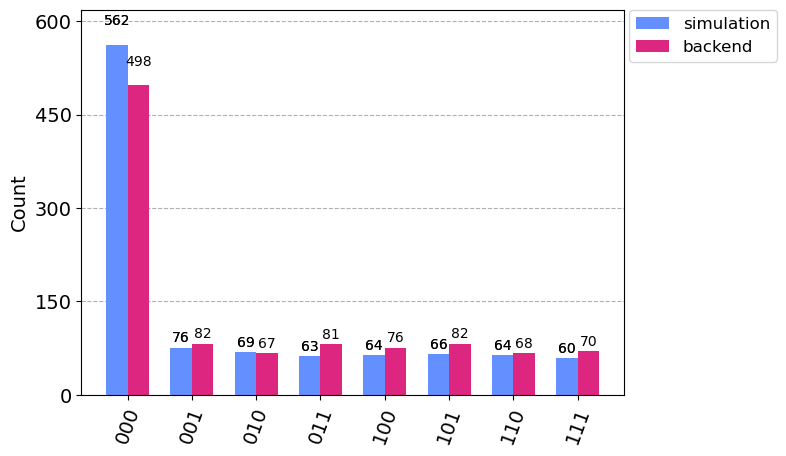

In [54]:
plot_histogram([sim_counts, counts], legend=['simulation', 'backend'])

In [55]:
import qiskit_ibm_runtime
import qiskit

print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")
print(f"qiskit version {qiskit.version.get_version_info()}")

qiskit runtime version 0.23.0
qiskit version 1.0.2
